### prepare


In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
# import time
# from typing import List
# from pathlib import Path
# import pickle

# import hydra
# from omegaconf import DictConfig

# import gym
# from gym.spaces import Box

# import numpy as np
# from sklearn.utils import check_random_state
# import matplotlib.pyplot as plt
# import pandas as pd
# from pandas import DataFrame
# import torch
# import seaborn as sns
# from cycler import cycler


# from d3rlpy.algos import SAC
# from d3rlpy.algos import DoubleDQN as DDQN
# from d3rlpy.algos import CQL
# from d3rlpy.algos import IQL
# from d3rlpy.algos import BCQ
# from d3rlpy.algos import DiscreteCQL
# from d3rlpy.algos import DiscreteBCQ
# from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy
# from d3rlpy.models.encoders import VectorEncoderFactory
# from d3rlpy.models.q_functions import MeanQFunctionFactory
# from d3rlpy.online.buffers import ReplayBuffer

# from scope_rl.dataset import SyntheticDataset
# from scope_rl.policy import BaseHead
# from scope_rl.policy import GaussianHead
# from scope_rl.policy import EpsilonGreedyHead
# from scope_rl.policy import SoftmaxHead
# from scope_rl.policy import TrainCandidatePolicies

# from scope_rl.ope.online import visualize_on_policy_policy_value
# from scope_rl.ope.online import calc_on_policy_policy_value

# from scope_rl.utils import MinMaxActionScaler
# from scope_rl.utils import OldGymAPIWrapper
# from scope_rl.types import LoggedDataset

# from experiments.utils import torch_seed, format_runtime

# from basicgym import BasicEnv

# from tutorial.function import train_behavior_policy
# from tutorial.function import obtain_logged_dataset
# from tutorial.function import train_candidate_policies
# # from experiments.main import off_policy_evaluation
# from tutorial.function import off_policy_evaluation

In [3]:
import time
from typing import List
from pathlib import Path
import pickle

import hydra
from omegaconf import DictConfig

import gym
from gym.spaces import Box

import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import torch
import seaborn as sns
from cycler import cycler
from basicgym import BasicEnv
from tutorial.function_before import train_behavior_policy
from tutorial.function_before import obtain_logged_dataset
from tutorial.function_before import train_candidate_policies
from tutorial.function_before import off_policy_evaluation
# from tutorial.function import train_behavior_policy
# from tutorial.function import obtain_logged_dataset
# from tutorial.function import train_candidate_policies
# from tutorial.function import off_policy_evaluation

/Users/ren/tutorial_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### function

In [4]:
def visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    estimators,
    ESTIMATORS,
    x_scales,
    x_label,
    log_dir="../tutorial/logs/",
    yscale_log = False,
    xscale_log = False,
):

    color_dict = {
        "dm": "#E24A33",
        "tis": "#348ABD",
        "pdis": "#988ED5",
        "dr": "#777777",
        "sntis": "#8EBA42",
        "snpdis": "#FBC15E",
        "sndr": "#FFB5B8",
        "sm_is": "#FFA726",
        "sm_dr": "#17BECF",
        "sm_snis": "#F781BF",
        "sm_sndr": "#8C564B",
        # "sam_is": "#00FF00",
        "sam_is": "#FFA726",
        "sam_dr": "#008080",
        "sam_snis": "#000080",
        "sam_sndr": "#4B0082",
        # "drl": "#800000"
        "drl": "#F781BF",
        "sope": "#DC143C",

    }

    plt.style.use("ggplot")
    markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]


    log_dir=log_dir

    metric_list = ['squared bias', 'variance', 'mse']

    for metric in metric_list:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
        if metric =='squared bias':
            result_df = bias_result_df
        elif metric == 'variance':
            result_df = variance_result_df
        else:
            result_df = mse_result_df

        for i, estimator in enumerate(estimators):
            data = result_df[result_df['est']==estimator]
            data = data.query(f"({min(x_scales)}<= {x_label} <= {max(x_scales)})")
            ax.plot(
                np.array(x_scales),
                data[metric],
                color=color_dict[estimator],
                marker=markers[i],
                label=ESTIMATORS[i],
            )
            
            ax.legend(ESTIMATORS, loc="upper right", fontsize=30)

            ax.fill_between(
                np.array(x_scales),
                data['lower'],
                data['upper'],
                color=color_dict[estimator],
                alpha=0.3,
                label='',
            )

        # title and legend
        ax.legend(loc="upper right", fontsize=30)
        # yaxis
        if yscale_log:
            ax.set_yscale("log")
        ax.set_ylabel(metric, fontsize=35)
        ax.tick_params(axis="y", labelsize=25)
        ax.yaxis.set_label_coords(-0.08, 0.5)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
        ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0', '1.2'])
        # xaxis
        if xscale_log:
            ax.set_xscale("log")
        ax.set_xlabel(f"number of step pdis", fontsize=25)
        ax.set_xticks(x_scales)
        ax.set_xticklabels(x_scales, fontsize=15)
        ax.xaxis.set_label_coords(0.5, -0.1)

        path_ = Path(log_dir + "/results/fig")
        path_.mkdir(exist_ok=True, parents=True)
        save_path = Path(path_ / f"{metric}_result_fig_{x_label}_{ESTIMATORS}.png")
        fig.tight_layout()
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

In [5]:
def main(
    variable_name,
    n_random_state,
    log_dir="../tutorial/logs/",
    behavior_tau = 1.0,
    candidate_epsilons = [1.0],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
):
    #discrete
    env_name="BasicEnv-discrete-v0"
    action_type='discrete'
    behavior_policy_name=f"ddqn_softmax_{behavior_tau}"
    candidate_policy_name=f"cql_eps_{candidate_epsilons[0]}"

    #continuous
    # env_name="BasicEnv-continuous-v0"
    # action_type='continuous'
    # behavior_policy_name=f"sac_gauss_{behavior_sigma}"
    # candidate_policy_name=f"cql_b1_gauss_{candidate_sigmas}"

    base_random_state=12345
    device="cuda:0" if torch.cuda.is_available() else "cpu"
    step_per_trajectory_list = [10, 15, 25, 40]
    step_per_trajectory = 15
    n_trajectories_list=[1600, 3200, 6400, 12800]
    n_trajectories=8000
    n_actions_list = [2, 4, 6, 8, 10, 12, 14, 16]
    n_actions=5
    # n_step_pdis_list=[0, 0, 0, 15]
    n_step_pdis_list=[0, 5, 10, 15]


    n_step_pdis=0
    
    bias_df_list = []
    variance_df_list = []
    mse_df_list = []
    bias_result_df = DataFrame()
    variance_df_result_df = DataFrame()
    mse_result_df = DataFrame()



    random_ = check_random_state(base_random_state)
    n_bootstrap_samples = 100
    alpha=0.05

    if variable_name == 'n_trajectories':
        variable_list = n_trajectories_list
    elif variable_name == 'n_actions':
        variable_list = n_actions_list
    elif variable_name == 'step_per_trajectory':
        variable_list = step_per_trajectory_list
    elif variable_name == 'n_step_pdis':
        variable_list = n_step_pdis_list
    else:
        ValueError


    for variable in variable_list:

        if variable_name == 'n_trajectories':
            n_trajectories = variable
        elif variable_name == 'n_actions':
            n_actions == variable
        elif variable_name == 'step_per_trajectory':
            step_per_trajectory =variable
        elif variable_name == 'n_step_pdis':
            n_step_pdis = variable

        env = BasicEnv(
            action_type=action_type, 
            n_actions=n_actions,
            random_state=base_random_state, 
            step_per_episode=step_per_trajectory,
        )

        behavior_policy = train_behavior_policy(
            env_name=env_name,
            env=env,
            behavior_sigma=behavior_sigma,
            behavior_tau=behavior_tau,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        train_logged_dataset, test_logged_dataset = obtain_logged_dataset(
            env_name=env_name,
            env=env,
            behavior_policy=behavior_policy,
            n_trajectories=n_trajectories,
            n_random_state=n_random_state,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        candidate_policies = train_candidate_policies(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            train_logged_dataset=train_logged_dataset,
            candidate_sigmas=candidate_sigmas,
            candidate_epsilons=candidate_epsilons,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict, policy_value_dict = off_policy_evaluation(
            env_name=env_name,
            env=env,
            n_trajectories=n_trajectories,
            test_logged_dataset=test_logged_dataset,
            candidate_policies=candidate_policies,
            n_step_pdis=n_step_pdis,
            device=device,
            base_random_state=base_random_state,
            log_dir=log_dir,
            variable=variable,
            variable_name=variable_name,
        )

        input_dict_ = input_dict.get(
            behavior_policy_name=behavior_policy_name,
            dataset_id=0,
        )

        dict = {i : DataFrame() for i in input_dict_.keys()}
        bias_dict = {i : 0 for i in input_dict_.keys()}
        variance_dict = {i : 0 for i in input_dict_.keys()}
        mse_dict = {i : 0 for i in input_dict_.keys()}
        lower_bias = []
        upper_bias = []
        lower_variance = []
        upper_variance = []
        lower_mse = []
        upper_mse = []

        for dataset_id_ in range(n_random_state):
            for eval_policy in input_dict_.keys():
                dict[eval_policy] = pd.concat([dict[eval_policy] , DataFrame(policy_value_dict[behavior_policy_name][dataset_id_][eval_policy], index=[dataset_id_])])

        for eval_policy in input_dict_.keys():
            bias_dict[eval_policy] = np.square(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
            variance_dict[eval_policy] = dict[eval_policy].var(axis=0)
            mse_dict[eval_policy] = bias_dict[eval_policy] + variance_dict[eval_policy]

        for estimator in dict[eval_policy].columns.values:
            samples = dict[eval_policy][estimator]

            boot_samples_bias = np.square([
                np.mean(random_.choice(samples - dict[eval_policy].mean(axis=0)['on_policy'], size=samples.shape[0]))
                for i in range(n_bootstrap_samples)
            ])
            boot_samples_variance = [
                np.var(random_.choice(samples, size=samples.shape[0]), ddof=1)
                for i in range(n_bootstrap_samples)
            ]
            boot_samples_mse = boot_samples_bias + boot_samples_variance

            lower_bias.append(np.percentile(boot_samples_bias, 100 * (alpha / 2)))
            upper_bias.append(np.percentile(boot_samples_bias, 100 * (1.0 - alpha / 2)))
            lower_variance.append(np.percentile(boot_samples_variance, 100 * (alpha / 2)))
            upper_variance.append(np.percentile(boot_samples_variance, 100 * (1.0 - alpha / 2)))
            lower_mse.append(np.percentile(boot_samples_mse, 100 * (alpha / 2)))
            upper_mse.append(np.percentile(boot_samples_mse, 100 * (1.0 - alpha / 2)))


        bias_df = DataFrame(DataFrame(bias_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "squared bias"})
        bias_df['lower']=lower_bias
        bias_df['upper']=upper_bias
        bias_df[variable_name] = variable
        bias_df_list.append(bias_df)
        variance_df = DataFrame(DataFrame(variance_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "variance"})
        variance_df['lower']=lower_variance
        variance_df['upper']=upper_variance
        variance_df[variable_name] = variable
        variance_df_list.append(variance_df)
        mse_df = DataFrame(DataFrame(mse_dict[candidate_policy_name]).stack())\
        .reset_index(0).rename(columns={"level_0": "est", 0: "mse"})
        mse_df['lower']=lower_mse
        mse_df['upper']=upper_mse
        mse_df[variable_name] = variable
        mse_df_list.append(mse_df)


    # aggregate all results 
    bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
    variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
    mse_result_df = pd.concat(mse_df_list).reset_index(level=0)

    # if variable_name == "n_step_pdis":
    #     bias_result_df['est'].replace('sam_is', 'sope', inplace=True)
    #     bias_row_samis = bias_result_df.query('est == "sope" and n_step_pdis == 0')
    #     bias_row_samis['est'].replace('sope', 'sam_is', inplace=True)
    #     variance_result_df['est'].replace('sam_is', 'sope', inplace=True)
    #     variance_row_samis = variance_result_df.query('est == "sope" and n_step_pdis == 0')
    #     variance_row_samis['est'].replace('sope', 'sam_is', inplace=True)
    #     mse_result_df['est'].replace('sam_is', 'sope', inplace=True)
    #     mse_row_samis = mse_result_df.query('est == "sope" and n_step_pdis == 0')
    #     mse_row_samis['est'].replace('sope', 'sam_is', inplace=True)
    #     for n_step_pdis in n_step_pdis_list:
    #         bias_row_samis["n_step_pdis"]=n_step_pdis
    #         bias_result_df = pd.concat([bias_result_df, bias_row_samis])
    #         variance_row_samis["n_step_pdis"]=n_step_pdis
    #         variance_result_df = pd.concat([variance_result_df, variance_row_samis])
    #         mse_row_samis["n_step_pdis"]=n_step_pdis
    #         mse_result_df = pd.concat([mse_result_df, mse_row_samis])
    #     replacement_values = bias_result_df.loc[bias_result_df.query('est == "sope" and n_step_pdis == 15'), ['variance', 'lower', 'upper']].values[0]
    #     # replacement_value = bias_result_df.loc[bias_result_df['index'] == 54, ['variance', 'lower', 'upper']].values[0]
    #     bias_result_df[['bias', 'lower', 'upper']] = bias_result_df[['bias', 'lower', 'upper']].replace(replacement_values)


    path_ = Path(log_dir + f"/results/df")
    path_.mkdir(exist_ok=True, parents=True)
    path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
    path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
    path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")

    with open(path_bias, "wb") as f:
        pickle.dump(bias_result_df, f)
    with open(path_variance, "wb") as f:
        pickle.dump(variance_result_df, f)
    with open(path_mse, "wb") as f:
        pickle.dump(mse_result_df, f)

    return bias_result_df, variance_result_df, mse_result_df


### main

In [6]:
basic_estimators = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
state_marginal_estimators = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
state_action_marginal_estimators = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
drl_estimators = ["DRL"]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]
all_estimators_name = basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name

In [7]:
bias_result_df, variance_result_df, mse_result_df =main(
    variable_name = "n_step_pdis",
    n_random_state = 100,
    # n_random_state = 100,
    log_dir="../tutorial/logs_n_step_pdis/",
    behavior_tau = 3.5,
    # behavior_tau = 3.0,
    candidate_epsilons = [0.5],
    behavior_sigma = 1.0,
    candidate_sigmas = [1.0],
    action_type = 'discrete',
)

In [8]:
# ESTIMATORS=["DR", "PDIS"]
# estimators=["dr", "pdis"]
# ESTIMATORS=["TIS", "PDIS"]
# estimators=["tis", "pdis"]
# ESTIMATORS=["DM", "TIS"]
# estimators=["dm", "tis"]
# ESTIMATORS=["DR", "PDIS"]
# estimators=["dr", "pdis"]
# ESTIMATORS=["PDIS"]
# estimators=["pdis"]
# ESTIMATORS=["SAMIS"]
# estimators=["sam_is"]
ESTIMATORS=["SAMIS", "PDIS", "SOPE"]
estimators=["sam_is", "pdis", "sope"]

# index = basic_estimators_name.index('dm')
# basic_estimators.pop(index)
# basic_estimators_name.pop(index)

# ESTIMATORS=basic_estimators
# estimators=basic_estimators_name
# x_scales=[ 3200,4800, 6400]
# x_scales=[200, 400, 800, 1600, 3200,4800, 6400, 8000]
# x_scales=[1600, 3200, 6400, 12800]
# x_label='n_trajectories'
# x_scales=[2, 4, 6, 10, 12, 14, 16, 18, 20]
# x_scales=[2, 4, 6, 8, 10, 12, 14, 16]
# x_label='n_actions'
# x_scales=[10, 15, 25, 40]
# x_label='step_per_trajectory'
x_scales=[0, 5, 10, 15]
# x_scales=[0, 0, 0, 15]
x_label='n_step_pdis'

In [9]:
# bias_result_df = bias_result_df[bias_result_df["est"]=="sam_is"][6:10]
# variance_result_df = variance_result_df[variance_result_df["est"]=="sam_is"][6:10]
# mse_result_df = mse_result_df[mse_result_df["est"]=="sam_is"][6:10]

In [10]:
variance_result_df[variance_result_df["est"]=="pdis"]

,index,est,variance,lower,upper,n_step_pdis
3,0,pdis,0.364021,0.067973,0.899789,0
20,0,pdis,0.679634,0.063941,1.850451,5
37,0,pdis,0.313835,0.063928,0.746876,10
54,0,pdis,0.390689,0.062579,1.125900,15


In [11]:
# replacement_values = bias_result_df.loc[bias_result_df.query('est == "sope" and n_step_pdis == 15'), ['variance', 'lower', 'upper']].values[0]
# # replacement_value = bias_result_df.loc[bias_result_df['index'] == 54, ['variance', 'lower', 'upper']].values[0]
# bias_result_df[['bias', 'lower', 'upper']] = bias_result_df[['bias', 'lower', 'upper']].replace(replacement_values)

In [12]:
n_step_pdis_list=[0, 5, 10, 15]

bias_result_df['est'].replace('sam_is', 'sope', inplace=True)
bias_row_samis = bias_result_df.query('est == "sope" and n_step_pdis == 0')
bias_row_samis['est'].replace('sope', 'sam_is', inplace=True)
variance_result_df['est'].replace('sam_is', 'sope', inplace=True)
variance_row_samis = variance_result_df.query('est == "sope" and n_step_pdis == 0')
variance_row_samis['est'].replace('sope', 'sam_is', inplace=True)
mse_result_df['est'].replace('sam_is', 'sope', inplace=True)
mse_row_samis = mse_result_df.query('est == "sope" and n_step_pdis == 0')
mse_row_samis['est'].replace('sope', 'sam_is', inplace=True)
for n_step_pdis in n_step_pdis_list:
    bias_row_samis["n_step_pdis"]=n_step_pdis
    bias_result_df = pd.concat([bias_result_df, bias_row_samis])
    variance_row_samis["n_step_pdis"]=n_step_pdis
    variance_result_df = pd.concat([variance_result_df, variance_row_samis])
    mse_row_samis["n_step_pdis"]=n_step_pdis
    mse_result_df = pd.concat([mse_result_df, mse_row_samis])
condition = (bias_result_df['est'] == 'pdis')
bias_replacement_values = bias_result_df.loc[(bias_result_df['est'] == 'pdis') & (bias_result_df['n_step_pdis'] == 15), ['squared bias', 'lower', 'upper']].values[0]
variance_replacement_values = variance_result_df.loc[(variance_result_df['est'] == 'pdis') & (variance_result_df['n_step_pdis'] == 15), ['variance', 'lower', 'upper']].values[0]
mse_replacement_values = mse_result_df.loc[(mse_result_df['est'] == 'pdis') & (mse_result_df['n_step_pdis'] == 15), ['mse', 'lower', 'upper']].values[0]

bias_result_df.loc[condition, ['squared bias', 'lower', 'upper']] = bias_replacement_values
variance_result_df.loc[condition, ['variance', 'lower', 'upper']] = variance_replacement_values
mse_result_df.loc[condition, ['mse', 'lower', 'upper']] = mse_replacement_values



/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_34451/659139101.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bias_row_samis['est'].replace('sope', 'sam_is', inplace=True)
/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_34451/659139101.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variance_row_samis['est'].replace('sope', 'sam_is', inplace=True)
/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_34451/659139101.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [13]:
# import pandas as pd

# # 以前のコードを含む部分
# n_step_pdis_list=[0, 5, 10, 15]
# # 'sam_is' を 'sope' に置き換えたり、元に戻したりする部分
# bias_result_df['est'].replace('sam_is', 'sope', inplace=True)
# bias_row_samis = bias_result_df.query('est == "sope" and n_step_pdis == 0')
# bias_row_samis['est'].replace('sope', 'sam_is', inplace=True)
# variance_result_df['est'].replace('sam_is', 'sope', inplace=True)
# variance_row_samis = variance_result_df.query('est == "sope" and n_step_pdis == 0')
# variance_row_samis['est'].replace('sope', 'sam_is', inplace=True)
# mse_result_df['est'].replace('sam_is', 'sope', inplace=True)
# mse_row_samis = mse_result_df.query('est == "sope" and n_step_pdis == 0')
# mse_row_samis['est'].replace('sope', 'sam_is', inplace=True)

# for n_step_pdis in n_step_pdis_list:
#     bias_copy = bias_row_samis.copy()  # .copy() を追加してDataFrameのコピーを作成
#     bias_copy['n_step_pdis'] = n_step_pdis
#     bias_result_df = pd.concat([bias_result_df, bias_copy])

#     variance_copy = variance_row_samis.copy()
#     variance_copy['n_step_pdis'] = n_step_pdis
#     variance_result_df = pd.concat([variance_result_df, variance_copy])

#     mse_copy = mse_row_samis.copy()
#     mse_copy['n_step_pdis'] = n_step_pdis
#     mse_result_df = pd.concat([mse_result_df, mse_copy])

# # 'pdis' の値を置き換える部分

# bias_replacement_values = bias_result_df.loc[(bias_result_df['est'] == 'pdis') & (bias_result_df['n_step_pdis'] == 15), ['bias', 'lower', 'upper']].values[0]
# variance_replacement_values = variance_result_df.loc[(variance_result_df['est'] == 'pdis') & (variance_result_df['n_step_pdis'] == 15), ['variance', 'lower', 'upper']].values[0]
# mse_replacement_values = mse_result_df.loc[(mse_result_df['est'] == 'pdis') & (mse_result_df['n_step_pdis'] == 15), ['mse', 'lower', 'upper']].values[0]

# condition = (bias_result_df['est'] == 'pdis')

# # .loc を使用してコピーに対して値を設定することで警告を回避
# bias_result_df.loc[condition, ['bias', 'lower', 'upper']] = bias_replacement_values
# variance_result_df.loc[condition, ['variance', 'lower', 'upper']] = variance_replacement_values
# mse_result_df.loc[condition, ['mse', 'lower', 'upper']] = mse_replacement_values


In [14]:
# replacement_values = bias_result_df.loc[(bias_result_df['est'] == 'pdis') & (bias_result_df['n_step_pdis'] == 15), ['bias', 'lower', 'upper']].values[0]

In [15]:
# replacement_values

In [16]:
# bias_result_df[['bias', 'lower', 'upper']] = bias_result_df[['bias', 'lower', 'upper']].replace(replacement_values)

In [17]:
bias_result_df

,index,est,squared bias,lower,upper,n_step_pdis
0,0,on_policy,0.000000,4.301449e-09,0.000407,0
1,0,dm,1.800357,1.777199e+00,1.831012,0
2,0,tis,0.093776,4.690938e-04,0.392956,0
3,0,pdis,0.014641,3.267142e-04,0.046718,0
4,0,dr,0.010648,7.830743e-04,0.045218,0
...,...,...,...,...,...,...
67,0,drl,0.713112,7.085557e-01,0.719652,15
12,0,sam_is,0.861577,8.584020e-01,0.865579,0
12,0,sam_is,0.861577,8.584020e-01,0.865579,5
12,0,sam_is,0.861577,8.584020e-01,0.865579,10


In [18]:
# condition = (bias_result_df['est'] == 'pdis')

In [19]:

# bias_result_df.loc[condition, ['bias', 'lower', 'upper']] = replacement_values

# print(bias_result_df)

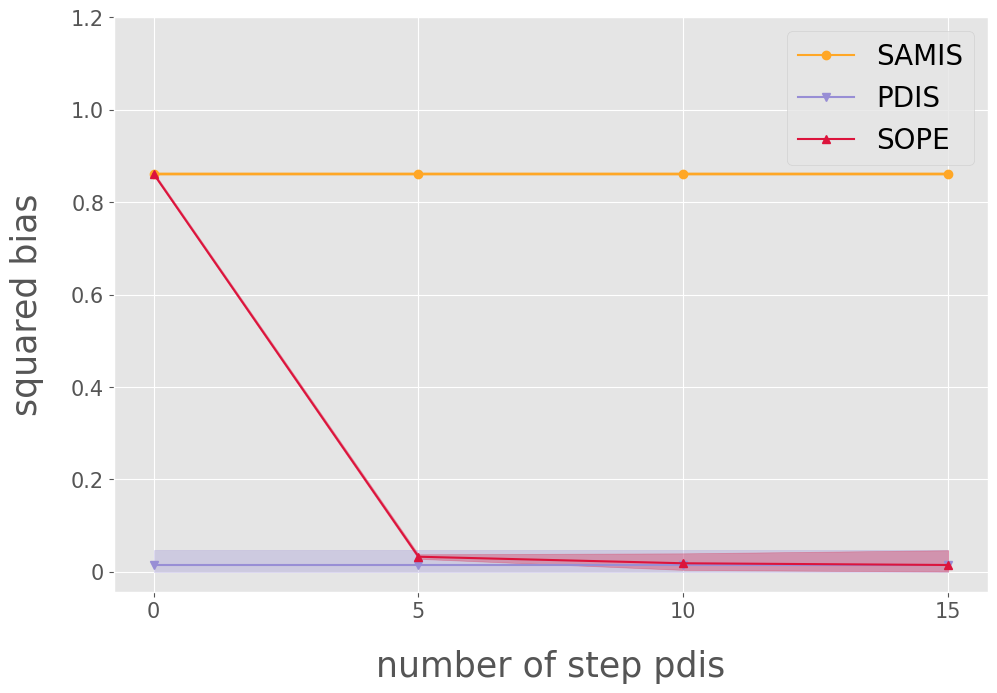

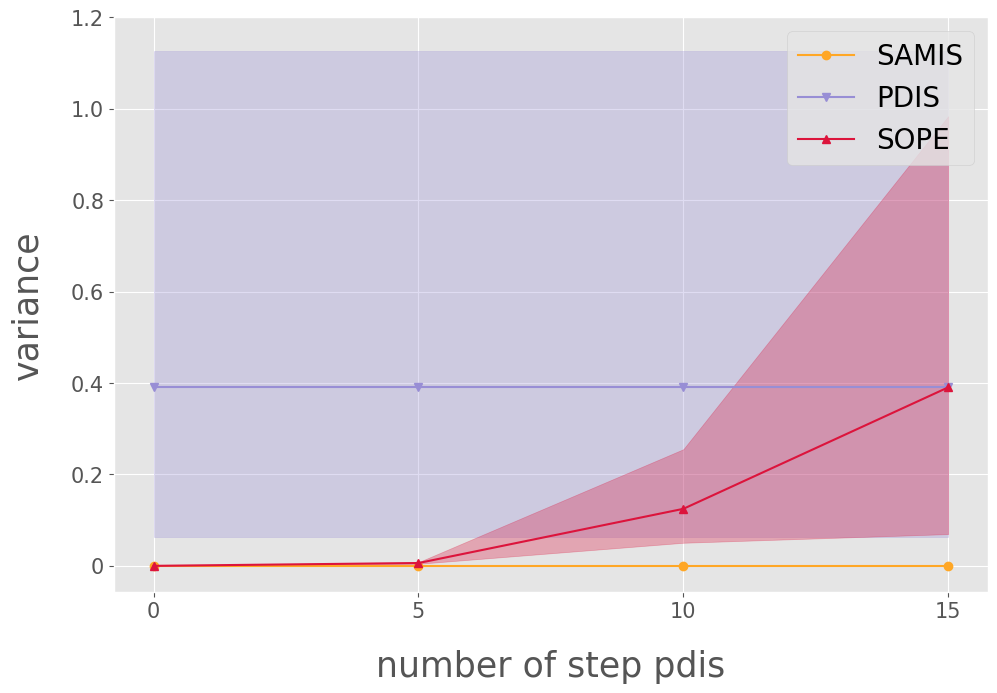

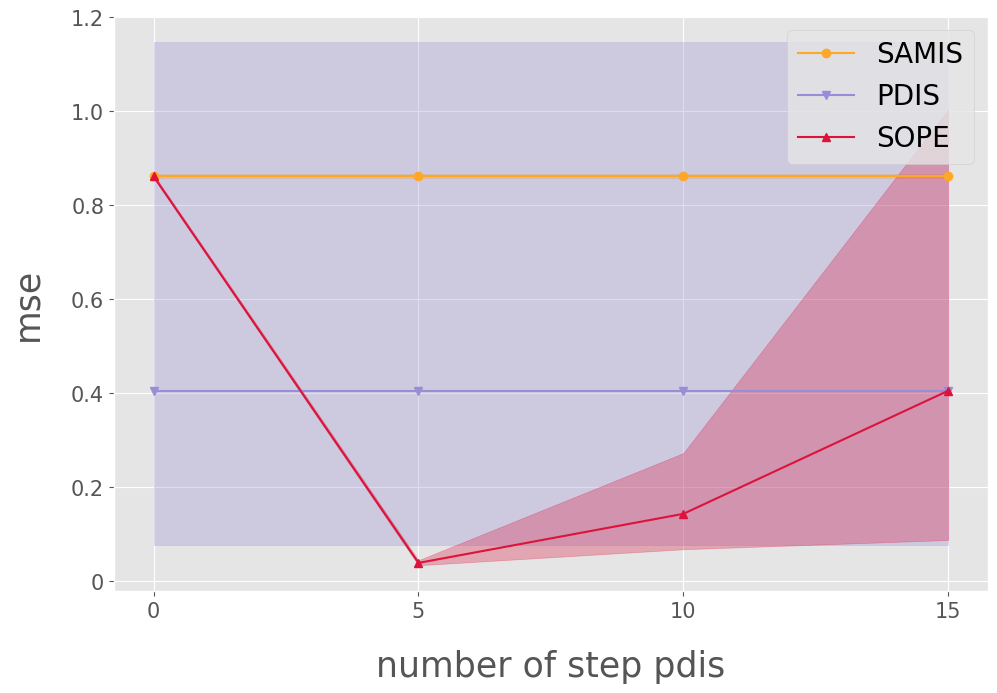

In [20]:
visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    ESTIMATORS=ESTIMATORS,
    estimators=estimators,
    log_dir="../tutorial/logs_n_step_pdis/",
    x_scales=x_scales,
    x_label=x_label,
    # yscale_log=True,
    # xscale_log=True,
)

In [21]:
bias_result_df[bias_result_df["est"
]=="pdis"]

,index,est,squared bias,lower,upper,n_step_pdis
3,0,pdis,0.014641,0.000327,0.046718,0
20,0,pdis,0.014641,0.000327,0.046718,5
37,0,pdis,0.014641,0.000327,0.046718,10
54,0,pdis,0.014641,0.000327,0.046718,15
